Окружение стоит ставить так.
в CMD:  

conda create -n py39_torch_1_11 python=3.8 pytorch=1.11 pyg -c pytorch -c pyg  
conda activate py39_torch_1_11   
pip install torch-geometric-temporal  

conda install -c anaconda ipykernel  
python -m ipykernel install --user --name=py39_torch_1_11  
conda install seaborn

# 1. Theory

## 1.1. Evolutions in a temporal graph

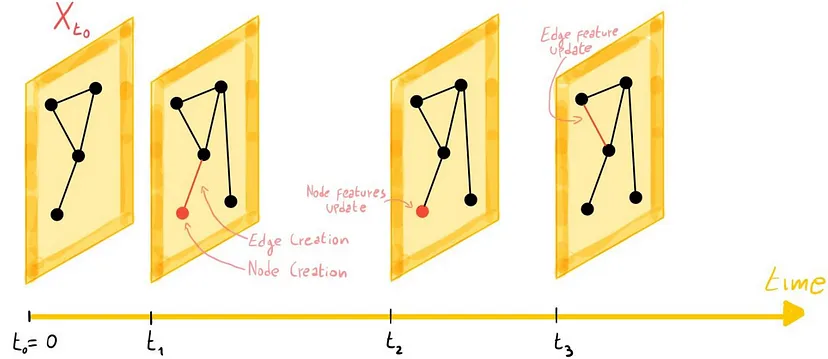

## 1.2. Time-and-graph and Time-then-graph

it saves space

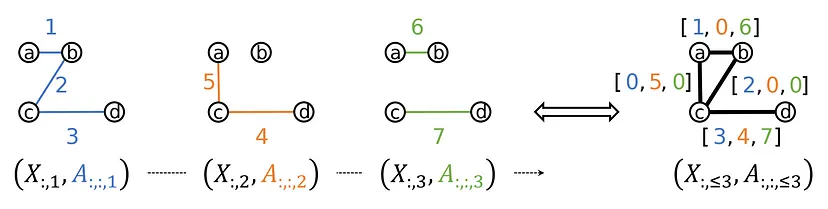

## 1.3. Models

Time + graph = too many opportunities

### 1.3.1. Dynamic GCN

Dynamic graph convolutional networks with attention mechanism for rumor detection on social media
Jiho Choi,Taewook Ko,Younhyuk Choi,Hyungho Byun,Chong-kwon Kim, 2019

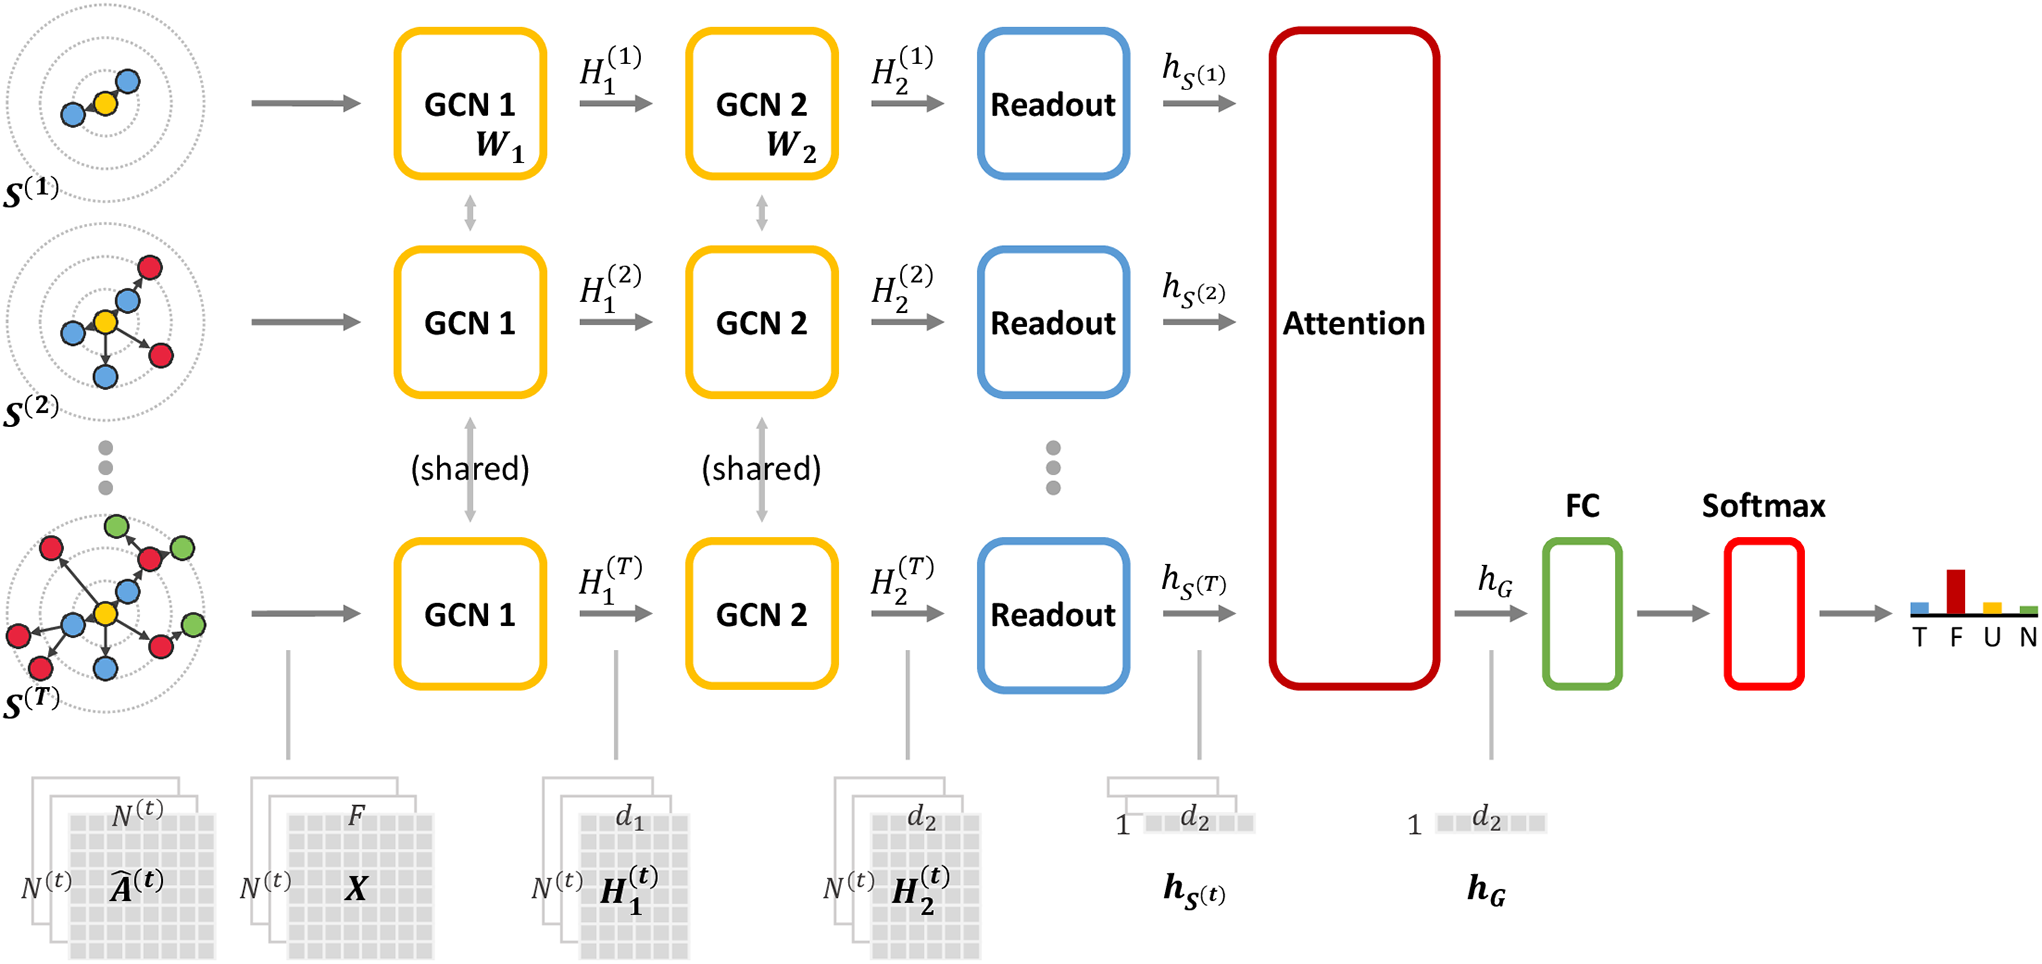

### Reminder: GCN architecture
$$\large\mathbf{x}^{\prime}_i = \mathbf{W}^{\top} \sum_{j \in
\mathcal{N}(i) \cup \{ i \}} \frac{1}{\sqrt{\hat{d}_j
\hat{d}_i}} \mathbf{x}_j
$$

где $\hat{d}_i $ - степень $i$-вершины $+ 1$,  
$\large\mathbf{x}_i$ - эмбеддинг $i$-вершины длины $\mathbf{k}$  
$\large\mathbf{x}^{\prime}_i$ - новый эмбеддинг $i$-вершины длины $\mathbf{k}^{\prime}$  
$\mathbf{W}$ - матрица размера $(\mathbf{k}, \mathbf{k}^{\prime})$  

### 1.3.2 EvolveGCN

EvolveGCN: Evolving Graph Convolutional Networks for Dynamic Graphs
Aldo Pareja, Giacomo Domeniconi, Jie Chen, Tengfei Ma, Toyotaro Suzumura, Hiroki Kanezashi, Tim Kaler, Tao B. Schardl, Charles E. Leiserson, 2019

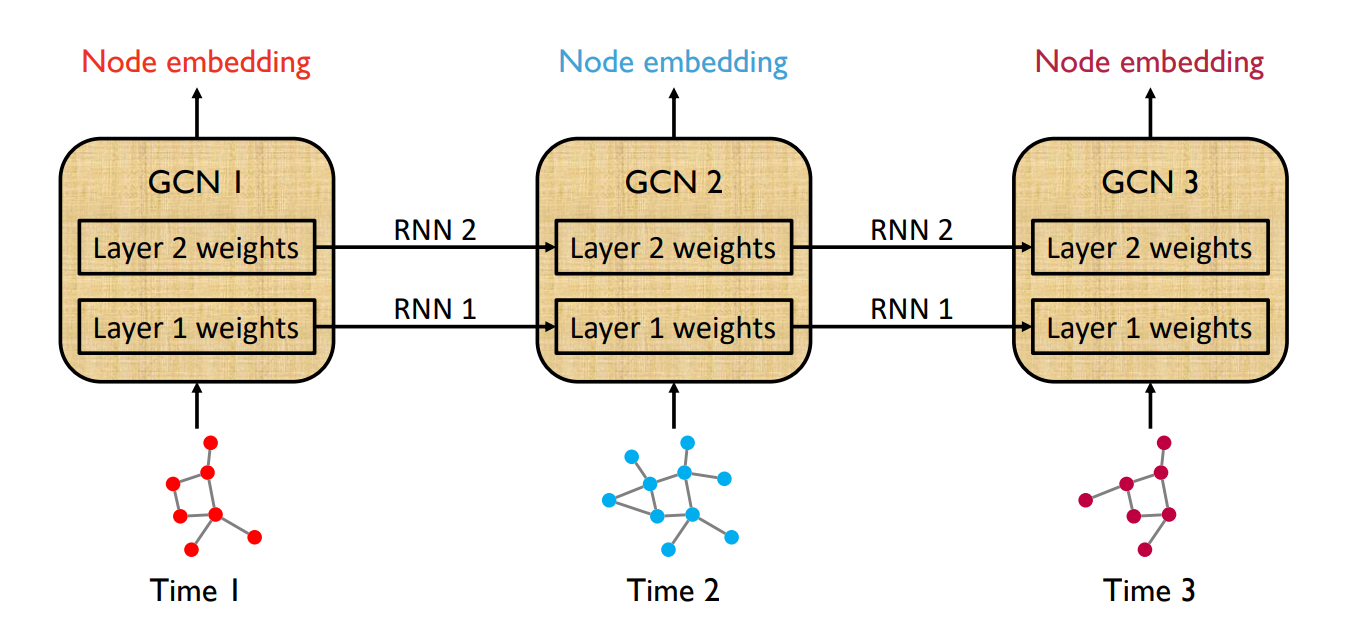

# 2. Practice

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import tqdm

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split


device = 'cuda' if torch.cuda.is_available() else 'cpu'
shuffle=True
batch_size = 32

C:\Users\Xiaomi\.conda\envs\py39_torch_1_11\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
1

1

<h1>
<center>A3T-GCN: Attention Temporal Graph
Convolutional Network for Traffic Forecasting</center>
</h1>


## Dataset
- Traffic forecasting dataset based on Los Angeles Metropolitan traffic 
- 207 loop detectors on highways
- March 2012 - June 2012
- From the paper: Diffusion Convolutional Recurrent Neural Network


In [3]:
# probably you need to download METR-LA.zip manually and place to 'data' folder
from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(list(dataset)))
print(next(iter(dataset))) # Show first sample

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x0000024C3B11B670>
Number of samples / sequences:  34249
Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])


In [4]:
sample

NameError: name 'sample' is not defined

#### Data Sample
- 207 nodes
- 2 features per node (speed, time)
- 12 timesteps per bucket (12 x 5 min = 60 min) 
- Labels for 12 future timesteps (normalized speed) --> node regression
- Edge_attr is build based on the distances between sensors + threshold
- Further details: https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/metr_la.html#METRLADatasetLoader
- Raw data: https://graphmining.ai/temporal_datasets/METR-LA.zip

### PLOT graph

C:\Users\Xiaomi\.conda\envs\py39_torch_1_11\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


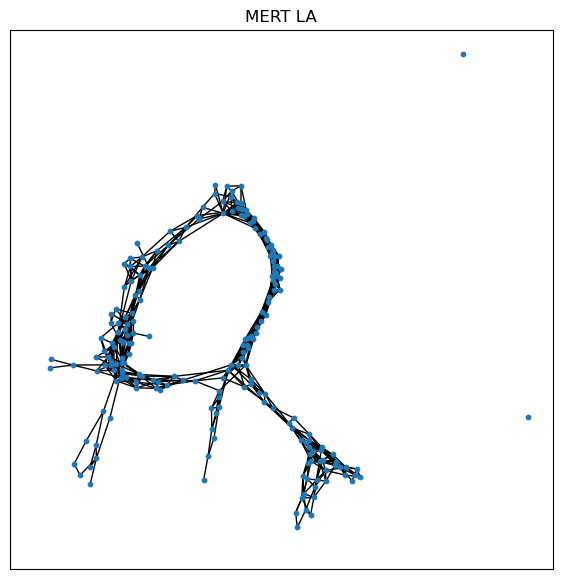

In [5]:
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_graph(G, title=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,node_size =10,
                      cmap="Set2")
    plt.title(title)
#     plt.show()

sample = next(iter(dataset))
sample.edge_index = sample.edge_index[:,sample.edge_index[0,:] != sample.edge_index[1,:]]
# Convert the PyG graph to NetworkX graph
G = to_networkx(sample, to_undirected=True)
visualize_graph(G,  title='MERT LA');

### Real map

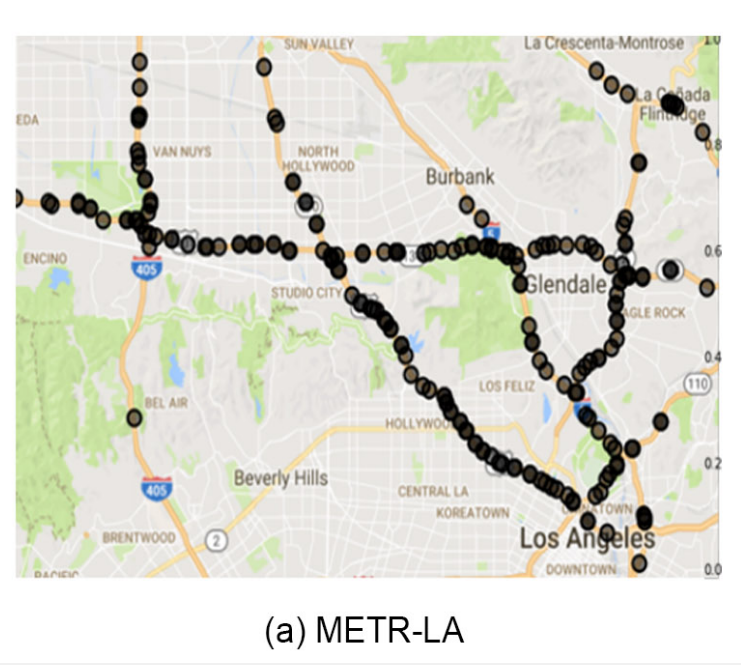

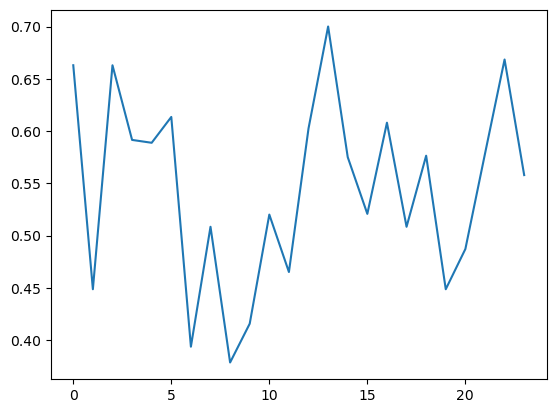

In [6]:
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
plt.plot(sensor_labels)

# Test Train Split

In [7]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", len(list(train_dataset)))
print("Number of test buckets: ", len(list(test_dataset)))

Number of train buckets:  27399
Number of test buckets:  6850


# Creating DataLoaders


In [8]:
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(device)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(device)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [9]:
test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(device)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(device)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

## Model

Which model to choose depends on which time-series task you work on. 

- A3TGCN is an extension of TGCN that uses attention 
- The spatial aggregation uses GCN, the temporal aggregation a GRU
- We can pass in periods to get an embedding for several timesteps
- This embedding can be used to predict several steps into the future = output dimension
- We could also do this in a loop and feed it again into the model (would be autoregressive)
- There is only one block here. Other layers also allow stacking???

<html>
<img src="https://i.ibb.co/WxrJQbc/a3tgcn.png", height="300"></img>

# TGCN model
A temporal GCN (T-GCN) model was constructed by combining GCN and GRU. 

n historical time series traffic data were inputted into the T-GCN model to obtain n hidden states (h) that covered spatiotemporal characteristics:{h(t−n), · · · , h(t−1), h(t)}


ut = σ(Wu ∗ (GC(A, Xt), ht−1)) 

rt = σ(Wr ∗ (GC(A, Xt), ht−1)) 

ct = tanh(Wc ∗ (GC(A, Xt), (rt ∗ ht−1)))

ht = ut ∗ ht−1 + (1 − ut) ∗ ct) 


Then, the hidden states were inputted into the attention model to determine the context vector that covers the global traffic variation information. Particularly, the weight of each h was calculated by Softmax using a multilayer perception:{at−n, · · · , at−1, at}.The context vector that covers global traffic variation information is calculated by the weighted sum. 


# A3TGCN Model
The A3TGCN is an extention of the TGCN model by adding an attention mechanism.

The attention mechanism was introduced to re-weight the influence of historical traffic states and thus to capture the global variation trends of traffic state

In [10]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12, batch_size=2)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

## Training

In [11]:

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12, batch_size=batch_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([12])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([12, 32])
linear.bias 	 torch.Size([12])
Net's total params: 6936
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}]


# Loading the graph once 
because it's a static graph

In [12]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(device)
    break;

In [13]:
import tqdm

In [14]:
model.train()

for epoch in range(1):
    step = 0
    loss_list = []
    for encoder_inputs, labels in tqdm.tqdm(train_loader):
        y_hat = model(encoder_inputs, static_edge_index)         # Get model predictions
        loss = loss_fn(y_hat, labels) # Mean squared error #loss = torch.mean((y_hat-labels)**2)  sqrt to change it to rmse
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step= step+ 1
        loss_list.append(loss.item())
        if step % 100 == 0 :
            print(sum(loss_list)/len(loss_list))
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

 12%|█▏        | 101/856 [00:22<02:27,  5.13it/s]

0.7626067671179771


 23%|██▎       | 200/856 [00:44<02:37,  4.18it/s]

0.625553280711174


 35%|███▌      | 300/856 [01:08<02:02,  4.53it/s]

0.5784753283858299


 47%|████▋     | 400/856 [01:31<01:53,  4.03it/s]

0.5553756181150675


 58%|█████▊    | 500/856 [01:54<01:30,  3.93it/s]

0.5374541607499123


 70%|███████   | 600/856 [02:18<01:11,  3.57it/s]

0.5293899631003539


 82%|████████▏ | 700/856 [02:42<00:36,  4.27it/s]

0.5224451418859618


 93%|█████████▎| 800/856 [03:04<00:13,  4.11it/s]

0.5147395825013519


100%|██████████| 856/856 [03:17<00:00,  4.34it/s]

Epoch 0 train RMSE: 0.5106


## Evaluation

- Lets get some sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
- The model always gets one hour and needs to predict the next hour

In [15]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 0.5859


### Visualization

- The further away the point in time is, the worse the predictions get
- Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [20]:
sensor = 72
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


<Axes: >

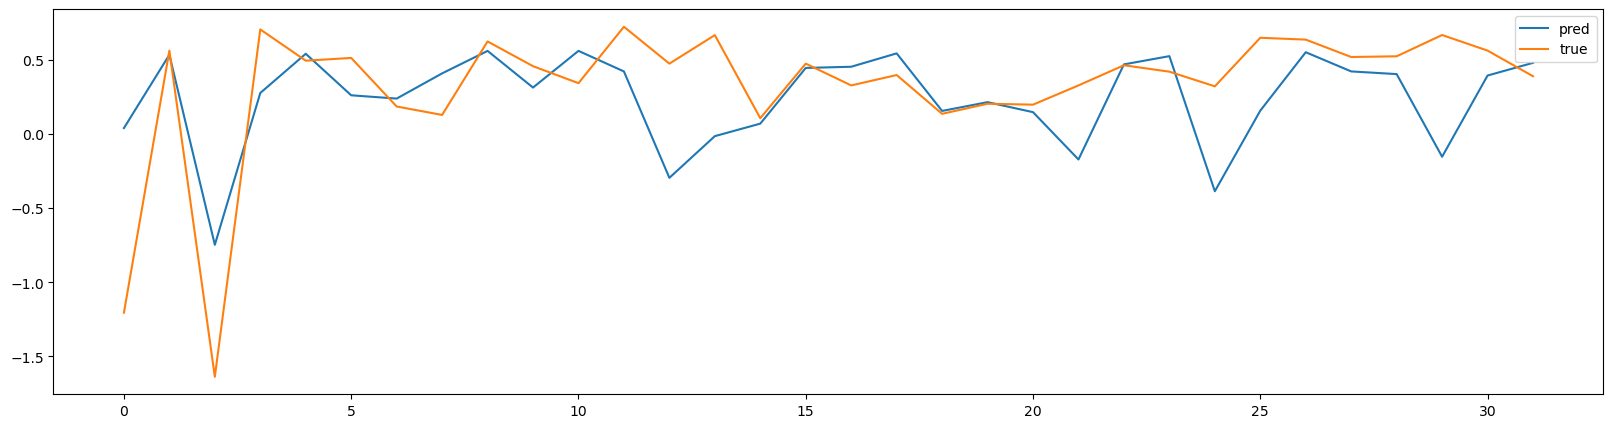

In [21]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

# 3. ACTION Recognition

## Action recognition by ST-GCN


Motion recognition from skeleton data

---



It performs motion recognition from skeletal data.
Behavior recognition determines what behavior the person does (throw, kick, jump...The task is to recognize what you are doing.
There are methods for motion recognition, such as images, but here we use skeletal data.

### Skeleton data

Skeleton data is the joint coordinates for each frame.
However, plain data is just coordinates, not graphs.

Human structure can be expressed in the connection between joints.In other words, humans can be represented as graphs.

By using the features (coordinates) of nodes and edges (joint connections), skeletal data is expressed as a graph.
By expressing it in a graph, you can consider the relationship between joints.

Through Graph Convolutional Networks (GCN), the skeletal data represented by the graph is recognized as what it is doing.

The video below shows an example of a graph representation of skeletal data.

<!--
<img src='https://drive.google.com/uc?id=1WrYd80u9buVcmBnpsgSZnzFlsYMih7Nr' width=30%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/03_throw_skeleton.gif?raw=true' width=30%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_throw_skeleton.gif?raw=true' width=30%>

### Spatial Temporal Graph Convolutional Networks

---



Spatial Temporal Graph Convolutional Networks for Skeleton-Based Action Recognition (ST-GCN)
Sijie Yan, Yuanjun Xiong, Dahua Lin, 2019 [[arXiv](https://arxiv.org/abs/1801.07455)]

<!--
<img src='https://drive.google.com/uc?id=1ZRf-NF4S0P1VwMxN2DrTFPeO4EJ5if3S' width=100%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/03_st-gcn.png?raw=true' width=100%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_st-gcn.png?raw=true' width=100%>

The characteristic of ST-GCN is that skeletal data is represented as 2 graph structures.
- Spatial graph: Graph connecting joints in the same frame
- Time graph: Graph connecting the same joints of adjacent frames

By extracting features from spatial and temporal graphs using Graph Covnolution, relationships between joints and temporal changes are taken into account.

<!--
<img src='https://drive.google.com/uc?id=1FDOGPZxaIYs-be-6tZzPeBsrtMcBXcuv' width=30%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/03_st_graph.png?raw=true' width=30%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_st_graph.png?raw=true' width=30%>

## Preparation before implementation

---




Import required Modules

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

using GPU

In [23]:
print('Use CUDA:', torch.cuda.is_available())

Use CUDA: True


Fixed seed value

In [24]:
seed = 123
# Numpy
np.random.seed(seed)
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

## Dataset

---


Download the dataset.This time, we have prepared a small original dataset (Note 1), so we will use it.
The number of operating classes is 10 (0 to 9).The operations are as follows.
* 0: Drink
* 1: Throw
* 2: Sit
* 3: Stand up
* 4: Applause
* 5: Wave your hand
* 6: Kick
* 7: Jump
* 8: Salute
* 9: Fall







Note 1: This dataset is [NTU-RGB+D dataset](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Shahroudy_NTU_RGBD_A_CVPR_2016_paper.pdf).  
Portions of the research used the NTU RGB+D Action Recognition Dataset made available by the ROSE Lab at the Nanyang Technological University, Singapore.

In [ ]:
!wget -q http://mprg.cs.chubu.ac.jp/~itaya/share/mprg_colab/NTU-RGBD_data/data.zip
!unzip -q -o data.zip

The number of training data is 2000 (10 classes × 200 data) and the number of evaluation data is 200 (10 classes ×20 data).

Check the structure of the data.

In [26]:
test_data = np.load("data/test_data.npy")
print(test_data[0].shape)

(3, 80, 25)


It is the structure of (number of dimensions, number of frames, number of joints=nodes).
1 Per data, 3D coordinates of 25 joints are included for 80 frames.

In [27]:
# Function for reading data
class Feeder(torch.utils.data.Dataset):
  def __init__(self, data_path, label_path):
      super().__init__()
      self.label = np.load(label_path)
      self.data = np.load(data_path)

  def __len__(self):
      return len(self.label)

  def __iter__(self):
      return self

  def __getitem__(self, index):
      data = np.array(self.data[index])
      label = self.label[index]

      return data, label

### Create adjacency matrix

Now we only have coordinate data (node features), so it is not a graph.
Define the connection relationship and graph it.Use adjacency matrices to represent connection relationships.
We will make it a class. Call it when you define the model.

Since it is difficult to edit the adjacency matrix manually, we prepare the connection relationship as an array and create the adjacency matrix based on it.

In [28]:
class Graph():
  def __init__(self, hop_size):
    # Declare an edge array. {{start, end}, {start, end}, ... , {start, end}
    # ...Declare one edge as an element, like }.
    self.get_edge()

    # hop: hop Tie the joint a few minutes away.
    # For example, with hop=2, the wrist is connected not only to the elbow but also to the shoulder.
    self.hop_size = hop_size
    self.hop_dis = self.get_hop_distance(self.num_node, self.edge, hop_size=hop_size)

    # Make an adjacency matrix.Here we create an adjacency matrix for each hop number.
    # When hop is 2, 3 adjacency matrices are created: 0hop, 1hop, and 2hop.
    # Multiple generation methods have been proposed in the paper. This time I used something easy to understand.
    self.get_adjacency()

  def __str__(self):
    return self.A

  def get_edge(self):
    self.num_node = 25
    self_link = [(i, i) for i in range(self.num_node)] # Loop
    neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12)]
    neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_base]
    self.edge = self_link + neighbor_link

  def get_adjacency(self):
    valid_hop = range(0, self.hop_size + 1, 1)
    adjacency = np.zeros((self.num_node, self.num_node))
    for hop in valid_hop:
        adjacency[self.hop_dis == hop] = 1
    normalize_adjacency = self.normalize_digraph(adjacency)
    A = np.zeros((len(valid_hop), self.num_node, self.num_node))
    for i, hop in enumerate(valid_hop):
        A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
    self.A = A

  def get_hop_distance(self, num_node, edge, hop_size):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(hop_size + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(hop_size, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis

  def normalize_digraph(self, A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    DAD = np.dot(A, Dn)
    return DAD

## ST-GCN implementation

---



### Spatial graph convolution

First, we will implement graph convolution of a spatial graph (human connection pattern).
The formula is almost the same as the Graph Convolution shown last time (node classification using Graph Convolutional Networks).
\begin{equation}
{\bf H}_{out}=\sum_{j}{\bf\tilde D}^{-\frac{1}{2}}_j{\bf\tilde A}_j{\bf\tilde D}^{-\frac{1}{2}}_j{\bf H}_{in}{\bf W}_{j}
\end{equation}
Since there are as many adjacency matrices ($j$: number of adjacency matrices) as there are hops, we convolve with each adjacency matrix and then add the features.

The implementation has been changed from the previous GC for faster speed and future scalability.


In [29]:
class SpatialGraphConvolution(nn.Module):
  def __init__(self, in_channels, out_channels, s_kernel_size):
    super().__init__()
    self.s_kernel_size = s_kernel_size
    self.conv = nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels * s_kernel_size,
                          kernel_size=1)

  def forward(self, x, A):
    x = self.conv(x)
    n, kc, t, v = x.size()
    x = x.view(n, self.s_kernel_size, kc//self.s_kernel_size, t, v)
    # Performs GC on the adjacency matrix and adds the features.
    x = torch.einsum('nkctv,kvw->nctw', (x, A))
    return x.contiguous()

### Convolution of time graph

Time graphs can be implemented using general 2D convolution processing instead of graph convolution processing.
The feature map has the form (number of frames x number of joints). A time graph is a graph that connects the same joints in the frame direction.
Since it only needs to be convolved in the frame direction, it can be implemented with a 2d convolution filter ($T\times 1$).

In addition, ST-GCN alternately convolves the spatial graph and the temporal graph.
Since we will be repeating this, we will create a class (STGC_block) that has a space graph, a time graph, and other functions (activation function and dropout).

In [30]:
class STGC_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5):
        super().__init__()
        # Convolution of spatial graph
        self.sgc = SpatialGraphConvolution(in_channels=in_channels,
                                           out_channels=out_channels,
                                           s_kernel_size=A_size[0])

        # Learnable weight matrix M Give weights to edges. Learn which edges are important.
        self.M = nn.Parameter(torch.ones(A_size))

        self.tgc = nn.Sequential(nn.BatchNorm2d(out_channels),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Conv2d(out_channels,
                                          out_channels,
                                          (t_kernel_size, 1),
                                          (stride, 1),
                                          ((t_kernel_size - 1) // 2, 0)),
                                nn.BatchNorm2d(out_channels),
                                nn.ReLU())

    def forward(self, x, A):
        x = self.tgc(self.sgc(x, A * self.M))
        return x

### Network model

In [31]:
class ST_GCN(nn.Module):
    def __init__(self, num_classes, in_channels, t_kernel_size, hop_size):
        super().__init__()
        # graph creation
        graph = Graph(hop_size)
        A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
        self.register_buffer('A', A)
        A_size = A.size()

        # Batch Normalization
        self.bn = nn.BatchNorm1d(in_channels * A_size[1])

        # STGC_blocks
        self.stgc1 = STGC_block(in_channels, 32, 1, t_kernel_size, A_size)
        self.stgc2 = STGC_block(32, 32, 1, t_kernel_size, A_size)
        self.stgc3 = STGC_block(32, 32, 1, t_kernel_size, A_size)
        self.stgc4 = STGC_block(32, 64, 2, t_kernel_size, A_size)
        self.stgc5 = STGC_block(64, 64, 1, t_kernel_size, A_size)
        self.stgc6 = STGC_block(64, 64, 1, t_kernel_size, A_size)

        # Prediction
        self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Batch Normalization
        N, C, T, V = x.size() # batch, channel, frame, node
        x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
        x = self.bn(x)
        x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

        # STGC_blocks
        x = self.stgc1(x, self.A)
        x = self.stgc2(x, self.A)
        x = self.stgc3(x, self.A)
        x = self.stgc4(x, self.A)
        x = self.stgc5(x, self.A)
        x = self.stgc6(x, self.A)

        # Prediction
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(N, -1, 1, 1)
        x = self.fc(x)
        x = x.view(x.size(0), -1)
        return x

## Training the model

---



In [32]:
NUM_EPOCH = 80#100-optim
BATCH_SIZE = 64

# create model
model = ST_GCN(num_classes=10,
                  in_channels=3,
                  t_kernel_size=9, # Kernel size for time graph convolution (t_kernel_size × 1)
                  hop_size=2).cuda()


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


criterion = torch.nn.CrossEntropyLoss()

# Preparing the dataset
data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/train_data.npy', label_path='data/train_label.npy'), batch_size=BATCH_SIZE, shuffle=True,)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy'), batch_size=BATCH_SIZE, shuffle=False)

# Change model to learning mode
model.train()

# Start learning
for epoch in tqdm.tqdm(range(1, NUM_EPOCH+1)):
  correct = 0
  sum_loss = 0
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    data = data.cuda()
    label = label.cuda()

    output = model(data)

    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()

  print('# Epoch: {} | Loss: {:.4f} | Accuracy: {:.4f}'.format(epoch, sum_loss/len(data_loader['train'].dataset), (100. * correct / len(data_loader['train'].dataset))))

  1%|▏         | 1/80 [00:10<13:30, 10.26s/it]

# Epoch: 1 | Loss: 0.0359 | Accuracy: 15.1000


  2%|▎         | 2/80 [00:18<11:36,  8.93s/it]

# Epoch: 2 | Loss: 0.0345 | Accuracy: 20.3000


  4%|▍         | 3/80 [00:26<10:55,  8.51s/it]

# Epoch: 3 | Loss: 0.0339 | Accuracy: 22.9000


  5%|▌         | 4/80 [00:34<10:32,  8.32s/it]

# Epoch: 4 | Loss: 0.0331 | Accuracy: 24.1000


  6%|▋         | 5/80 [00:42<10:16,  8.22s/it]

# Epoch: 5 | Loss: 0.0316 | Accuracy: 28.8500


  8%|▊         | 6/80 [00:50<10:03,  8.15s/it]

# Epoch: 6 | Loss: 0.0299 | Accuracy: 32.3000


  9%|▉         | 7/80 [00:58<09:52,  8.11s/it]

# Epoch: 7 | Loss: 0.0287 | Accuracy: 35.0500


 10%|█         | 8/80 [01:06<09:43,  8.10s/it]

# Epoch: 8 | Loss: 0.0273 | Accuracy: 39.6000


 11%|█▏        | 9/80 [01:14<09:33,  8.08s/it]

# Epoch: 9 | Loss: 0.0253 | Accuracy: 44.2500


 12%|█▎        | 10/80 [01:22<09:25,  8.08s/it]

# Epoch: 10 | Loss: 0.0221 | Accuracy: 51.1000


 14%|█▍        | 11/80 [01:30<09:16,  8.07s/it]

# Epoch: 11 | Loss: 0.0199 | Accuracy: 55.7500


 15%|█▌        | 12/80 [01:38<09:08,  8.07s/it]

# Epoch: 12 | Loss: 0.0181 | Accuracy: 59.2000


 16%|█▋        | 13/80 [01:46<09:00,  8.06s/it]

# Epoch: 13 | Loss: 0.0181 | Accuracy: 58.9000


 18%|█▊        | 14/80 [01:54<08:51,  8.06s/it]

# Epoch: 14 | Loss: 0.0167 | Accuracy: 61.0500


 19%|█▉        | 15/80 [02:02<08:43,  8.05s/it]

# Epoch: 15 | Loss: 0.0162 | Accuracy: 62.3500


 20%|██        | 16/80 [02:10<08:34,  8.04s/it]

# Epoch: 16 | Loss: 0.0164 | Accuracy: 62.3500


 21%|██▏       | 17/80 [02:18<08:26,  8.04s/it]

# Epoch: 17 | Loss: 0.0157 | Accuracy: 63.0500


 22%|██▎       | 18/80 [02:26<08:19,  8.05s/it]

# Epoch: 18 | Loss: 0.0149 | Accuracy: 66.0500


 24%|██▍       | 19/80 [02:35<08:15,  8.13s/it]

# Epoch: 19 | Loss: 0.0145 | Accuracy: 67.9000


 25%|██▌       | 20/80 [02:43<08:07,  8.12s/it]

# Epoch: 20 | Loss: 0.0142 | Accuracy: 68.7500


 26%|██▋       | 21/80 [02:51<07:57,  8.10s/it]

# Epoch: 21 | Loss: 0.0145 | Accuracy: 67.9000


 28%|██▊       | 22/80 [02:59<07:48,  8.09s/it]

# Epoch: 22 | Loss: 0.0139 | Accuracy: 70.3500


 29%|██▉       | 23/80 [03:07<07:40,  8.07s/it]

# Epoch: 23 | Loss: 0.0131 | Accuracy: 72.4500


 30%|███       | 24/80 [03:15<07:31,  8.07s/it]

# Epoch: 24 | Loss: 0.0122 | Accuracy: 74.9500


 31%|███▏      | 25/80 [03:23<07:24,  8.07s/it]

# Epoch: 25 | Loss: 0.0114 | Accuracy: 75.8000


 32%|███▎      | 26/80 [03:31<07:17,  8.10s/it]

# Epoch: 26 | Loss: 0.0113 | Accuracy: 76.2000


 34%|███▍      | 27/80 [03:39<07:09,  8.10s/it]

# Epoch: 27 | Loss: 0.0105 | Accuracy: 77.9500


 35%|███▌      | 28/80 [03:48<07:01,  8.10s/it]

# Epoch: 28 | Loss: 0.0108 | Accuracy: 77.6500


 36%|███▋      | 29/80 [03:56<06:52,  8.09s/it]

# Epoch: 29 | Loss: 0.0100 | Accuracy: 79.1000


 38%|███▊      | 30/80 [04:04<06:45,  8.10s/it]

# Epoch: 30 | Loss: 0.0098 | Accuracy: 79.9000


 39%|███▉      | 31/80 [04:12<06:36,  8.09s/it]

# Epoch: 31 | Loss: 0.0095 | Accuracy: 79.8500


 40%|████      | 32/80 [04:20<06:28,  8.10s/it]

# Epoch: 32 | Loss: 0.0090 | Accuracy: 81.1000


 41%|████▏     | 33/80 [04:28<06:20,  8.10s/it]

# Epoch: 33 | Loss: 0.0090 | Accuracy: 80.1000


 42%|████▎     | 34/80 [04:36<06:12,  8.10s/it]

# Epoch: 34 | Loss: 0.0090 | Accuracy: 80.5500


 44%|████▍     | 35/80 [04:44<06:04,  8.09s/it]

# Epoch: 35 | Loss: 0.0084 | Accuracy: 82.6500


 45%|████▌     | 36/80 [04:52<05:56,  8.09s/it]

# Epoch: 36 | Loss: 0.0085 | Accuracy: 82.6500


 46%|████▋     | 37/80 [05:00<05:47,  8.09s/it]

# Epoch: 37 | Loss: 0.0082 | Accuracy: 82.7000


 48%|████▊     | 38/80 [05:08<05:40,  8.10s/it]

# Epoch: 38 | Loss: 0.0077 | Accuracy: 83.1500


 49%|████▉     | 39/80 [05:17<05:31,  8.09s/it]

# Epoch: 39 | Loss: 0.0076 | Accuracy: 83.3500


 50%|█████     | 40/80 [05:25<05:24,  8.10s/it]

# Epoch: 40 | Loss: 0.0072 | Accuracy: 84.2000


 51%|█████▏    | 41/80 [05:33<05:15,  8.10s/it]

# Epoch: 41 | Loss: 0.0074 | Accuracy: 84.2500


 52%|█████▎    | 42/80 [05:41<05:07,  8.10s/it]

# Epoch: 42 | Loss: 0.0080 | Accuracy: 84.0000


 54%|█████▍    | 43/80 [05:49<04:59,  8.10s/it]

# Epoch: 43 | Loss: 0.0077 | Accuracy: 83.9000


 55%|█████▌    | 44/80 [05:57<04:51,  8.10s/it]

# Epoch: 44 | Loss: 0.0079 | Accuracy: 83.5500


 56%|█████▋    | 45/80 [06:05<04:43,  8.09s/it]

# Epoch: 45 | Loss: 0.0068 | Accuracy: 84.8000


 57%|█████▊    | 46/80 [06:13<04:35,  8.10s/it]

# Epoch: 46 | Loss: 0.0067 | Accuracy: 84.8000


 59%|█████▉    | 47/80 [06:21<04:27,  8.09s/it]

# Epoch: 47 | Loss: 0.0062 | Accuracy: 86.6500


 60%|██████    | 48/80 [06:29<04:18,  8.09s/it]

# Epoch: 48 | Loss: 0.0065 | Accuracy: 85.2500


 61%|██████▏   | 49/80 [06:37<04:10,  8.09s/it]

# Epoch: 49 | Loss: 0.0067 | Accuracy: 85.9500


 62%|██████▎   | 50/80 [06:46<04:02,  8.09s/it]

# Epoch: 50 | Loss: 0.0064 | Accuracy: 85.7000


 64%|██████▍   | 51/80 [06:54<03:54,  8.09s/it]

# Epoch: 51 | Loss: 0.0064 | Accuracy: 85.2500


 65%|██████▌   | 52/80 [07:02<03:46,  8.09s/it]

# Epoch: 52 | Loss: 0.0062 | Accuracy: 86.6500


 65%|██████▌   | 52/80 [07:08<03:50,  8.24s/it]


KeyboardInterrupt: 

## Evaluation of the model

---



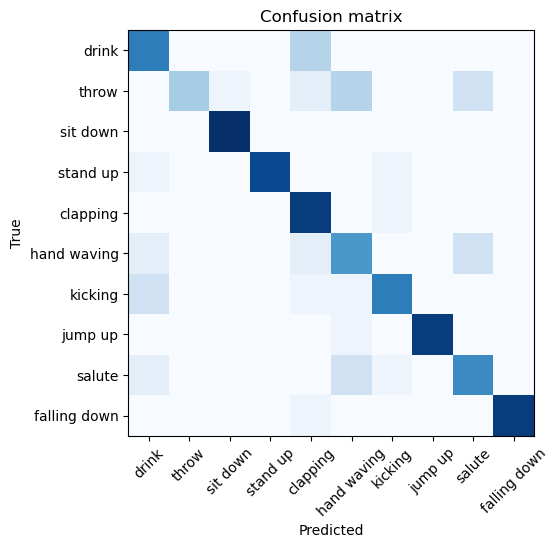

# Test Accuracy: 77.500[%]


In [33]:

model.eval()

correct = 0
confusion_matrix = np.zeros((10, 10))
with torch.no_grad():
  for batch_idx, (data, label) in enumerate(data_loader['test']):
    data = data.cuda()
    label = label.cuda()

    output = model(data)

    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()

    for l, p in zip(label.view(-1), predict.view(-1)):
      confusion_matrix[l.long(), p.long()] += 1

len_cm = len(confusion_matrix)
for i in range(len_cm):
    sum_cm = np.sum(confusion_matrix[i])
    for j in range(len_cm):
        confusion_matrix[i][j] = 100 * (confusion_matrix[i][j] / sum_cm)

classes = ['drink', 'throw', 'sit down', 'stand up', 'clapping', 'hand waving', 'kicking', 'jump up', 'salute', 'falling down']
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.tight_layout()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


print('# Test Accuracy: {:.3f}[%]'.format(100. * correct / len(data_loader['test'].dataset)))

Let's learn the network by changing the graph structure for the skeletal data.

The graph structure based on the skeletal pattern is designed by the author of the paper, and there is no need to follow it.
Free design of the graph structure is allowed.
Of course, there is no problem in tying joints that are far apart, such as the hands and feet.

Therefore, let's design the graph structure freely and discover a graph structure that increases recognition accuracy.
Various graph structures can be considered, such as connecting distant joints or increasing the number of edges.

`class Graph`of`neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12)]`  
The joints and joint numbers are as follows.

<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_skeleton.png?raw=true' width=30%>